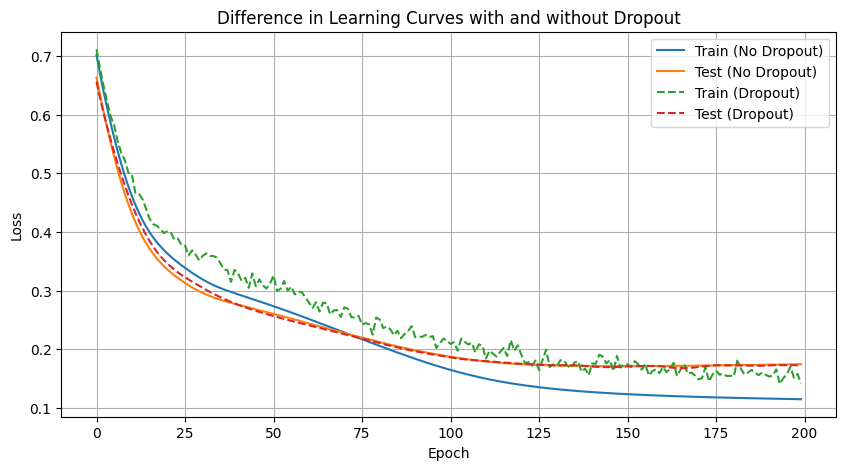

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# ===== データ作成（半月型、学習しやすいが過学習しやすい） =====
X, y = make_moons(n_samples=800, noise=0.25, random_state=0)
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.long)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# ===== モデル定義（Dropout なし） =====
class NetNoDropout(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 2)
        )
    def forward(self, x):
        return self.net(x)

# ===== モデル定義（Dropout あり） =====
class NetDropout(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 128),
            nn.ReLU(),
            nn.Dropout(0.5),  # ★ここが重要
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Dropout(0.5),  # ★ここも重要
            nn.Linear(128, 2)
        )
    def forward(self, x):
        return self.net(x)

# ===== モデル準備 =====
model_no = NetNoDropout()
model_do = NetDropout()

criterion = nn.CrossEntropyLoss()
optimizer_no = optim.Adam(model_no.parameters(), lr=0.001)
optimizer_do = optim.Adam(model_do.parameters(), lr=0.001)

# ===== 学習関数 =====
def train_model(model, optimizer, X_train, y_train, X_test, y_test, epochs=200):
    train_losses = []
    test_losses = []

    for epoch in range(epochs):
        # --- train ---
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

        # --- test ---
        model.eval()
        with torch.no_grad():
            test_outputs = model(X_test)
            test_loss = criterion(test_outputs, y_test)
            test_losses.append(test_loss.item())

    return train_losses, test_losses

# ===== 学習 =====
train_no, test_no = train_model(model_no, optimizer_no, X_train, y_train, X_test, y_test)
train_do, test_do = train_model(model_do, optimizer_do, X_train, y_train, X_test, y_test)

# ===== 可視化 =====
plt.figure(figsize=(10,5))
plt.title("Difference in Learning Curves with and without Dropout")
plt.plot(train_no, label="Train (No Dropout)")
plt.plot(test_no, label="Test (No Dropout)")
plt.plot(train_do, label="Train (Dropout)", linestyle="--")
plt.plot(test_do, label="Test (Dropout)", linestyle="--")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()
